In [1]:
# Load in the dependencies

%load_ext autoreload
%autoreload 2
from nn import nn, io, preprocess
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

I will first read in the data. We then have to make the negative examples the same sequence lengths as the positive examples. All of the positive examples have 17bp so I'll just loop through the negative sequences and create 17bp sub-sequences. 

In [2]:
positives = io.read_text_file("data/rap1-lieb-positives.txt")
negatives = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")


# Make the negative sequences the same length as the positive sequences 
# We see that each of the positive sequences is 17bp 

seq_length = len(positives[0])
negative_trimmed = []
for s in negatives:
    seq = str()
    for i in range(len(s)):
        seq = seq + s[i] 
        
        if i > 0 and i % seq_length == 0:
            negative_trimmed.append(seq)
            seq = str()
    
# Combine and create labels
sequences = positives + negative_trimmed
labels = [True] * len(positives) + [False] * len(negative_trimmed)

# ensure each example has proper number of base pairs
sequences = [s[:seq_length] for s in sequences]

# Print counts
print("Positive examples:", len(positives))
print("Negative examples:", len(negative_trimmed))

Positive examples: 137
Negative examples: 183296


We then see that we have to subsample such that we equal number of examples for both positive and negative sequences. I chose to implement a function that upsamples the smaller class. I think this makes sense here because there are so few positive examples - so if I were to downsample the bigger class, there would be too few examples to train (fewer after splitting between training and validation). This will increase the number of positive examples and overall number of labeled examples available. 

In [3]:
seqs, labels = preprocess.sample_seqs(np.array(sequences), np.array(labels))
print("Seq shapes", seqs.shape)
print("Label shapes", labels.shape)

Seq shapes (366592,)
Label shapes (366592,)


Now we will one hot encode the sequences. 

In [4]:
X = preprocess.one_hot_encode_seqs(seqs)

In [5]:
X

array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

Now, we can split the data into training and testing sets. I just use the sklearn train_test_split function to do this. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size = 0.2, random_state = 0)

Now, I create a tuning grid with different hyperparameter values. I will loop through all of the different combinations, fit a model and then select the best model. I chose to a sigmoid activation since it is designed for binary classification. Similarly, a binary cross entropy is also designed for classification tasks. I tested a few different layer architecture and didn't seem to matter too much so I just chose the architecture that I've seen before (where you half the number of nodes with each layer - see https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af). 

In [12]:
lr_grid = [1e-4, 1e-5, 1e-6]
batch_grid = [10, 50, 500]
epochs_grid = [5, 10, 20]

comb_array = np.array(np.meshgrid(lr_grid, batch_grid, epochs_grid)).T.reshape(-1, 3)
layers = [{"input_dim": 68, "output_dim": 34, "activation": "sigmoid"},
          {"input_dim": 34, "output_dim": 17, "activation": "sigmoid"},
          {"input_dim": 17, "output_dim": 1, "activation": "sigmoid"},]

# Need to reshape the y values in order to fit through net
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

Looping through tune grid (I had to stop this early since it was taking too long - but I went through a good number of parameters and they don't seem to make too much of a difference)

In [14]:
tune_grid = []
count = 0
for i in comb_array:
    count += 1 
    lr = i[0]
    batch_size = i[1]
    epochs = int(i[2])
    net = nn.NeuralNetwork(layers, lr = lr, seed = 42, batch_size = batch_size, epochs = epochs, loss_function = "bce")
    train_losses, val_losses = net.fit(X_train, y_train, X_test, y_test)
    # We want to save the test loss for the last epoch
    test_loss = val_losses[-1]
    tune_grid.append([lr, batch_size, epochs, test_loss])
    if count % 2 == 0 :
        print(count)


2
4
6
8
10
12
14
16
18
20
22
24
26
28


KeyboardInterrupt: 

In [15]:
grid = np.array(tune_grid)
min_key = np.argmin(grid[:,3])
print("Least MSE on validation data:", grid[:,3][min_key])
best_para=grid[min_key]
print("The optimal parameters:lr, batch_size, epochs, test loss:", best_para)

Least MSE on validation data: 0.22315567778606415
The optimal parameters:lr, batch_size, epochs, test loss: [1.00000000e-04 1.00000000e+01 2.00000000e+01 2.23155678e-01]


In [17]:
lr = best_para[0]
batch_size = best_para[1]
epochs = int(best_para[2])
net = nn.NeuralNetwork(layers, lr = lr, seed = 42, batch_size = batch_size, epochs = epochs, loss_function = "mse")
train_losses, val_losses = net.fit(X_train, y_train, X_test, y_test)

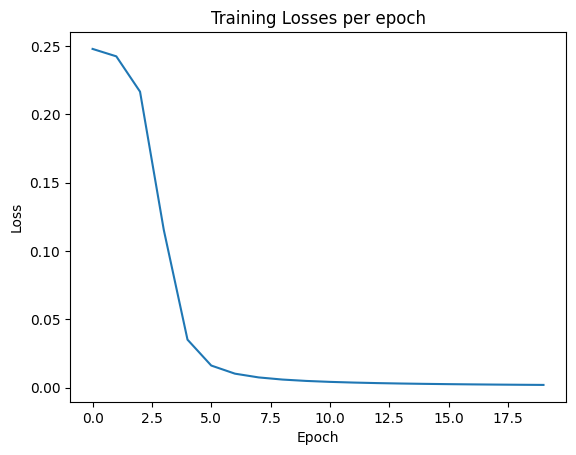

In [19]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Losses per epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

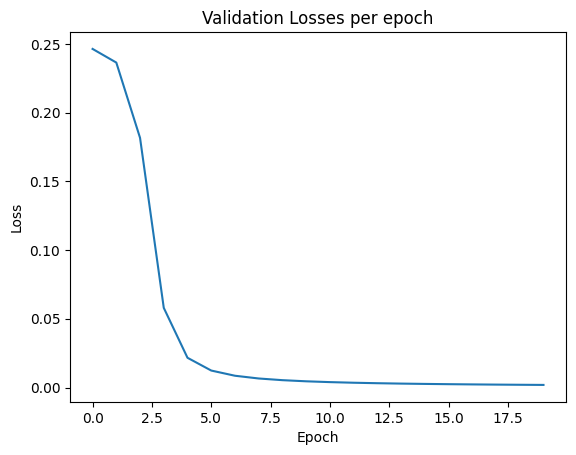

In [20]:
plt.figure()
plt.plot(val_losses)
plt.title("Validation Losses per epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

We can also calculate the validation accuracy of the classifier:

In [24]:
pred = (net.predict(X_test) >= 0.5).astype(int)
accuracy = np.sum(pred == y_test) / len(y_test)
print("Accuracy:", accuracy) 

Accuracy: 0.9989225166737135


So, we can see that the validation accuracy is 99.8%. I chose a bce as a loss function because this is for a binary classifier and hence this loss function makes the most sense. I also chose the hyperparameters by trying many different values and choosing the best set of parameters of the values tested. 